# Stochastic Nested Variance Reduction Gradient for Non-convex Optimization

This notebook implements the SNVRG algorithm proposed in this [paper](https://papers.nips.cc/paper/7648-stochastic-nested-variance-reduced-gradient-descent-for-nonconvex-optimization.pdf) by Dongruo Zhou et al.

We apply the SNVRG algorithm to a convex problem (Logistic regression with LASSO regularization) and a non-convex problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Toy Convex Problem: Logistic Regression with LASSO regularization

In [2]:
# Generate the data
n, p = 1000, 5

X = np.random.randn(n, p)
w = np.random.randn(p)

sigma = 1
xi = np.random.randn(n)

y = np.sign(X.dot(w) + sigma*xi)

In [3]:
# Define the loss function
def LASSO_loss(X, y, theta, lamda):
    '''Return the logistic LASSO loss for parameters `theta`.'''
    return np.mean(np.log(1.0 + np.exp(- y * X.dot(theta)))) + lamda * np.sum(np.abs(theta))

In [4]:
# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y/(1.0 + np.exp(y * X.dot(theta)))).dot(X) + LASSO_grad

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datum i.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y[i]/(1.0 + np.exp(y[i] * X[i].dot(theta)))) * X[i] + LASSO_grad

In [5]:
# Define the SVRG algorithm
def SVRG(X, y, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    theta_history = np.zeros((max_iter_inner, p))
    
    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
    
    return theta_hat, theta_hat_history, loss_history

In [6]:
theta = np.random.randn(p)
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history = SVRG(X, y, theta, lamda=0.1, max_iter=100, max_iter_inner=100, step_size=0.05)

In [7]:
# Define the approximative minimum value of the loss function
svrg_min_loss = np.min(svrg_loss_history)

In [8]:
# Define the function to find the mod index
def find_index(t, loop_params):
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    updated_reference = theta_reference.copy()
    K, p = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, p))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    n = X.shape[0]
    K, p = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

In [9]:
def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, p))
    theta_history = []
    
    gradients = np.zeros((K+1, p))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
#     final_theta = np.mean(theta_history, axis=0)
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

In [10]:
def SNVRG(X, y, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
    
    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history

First, we set the same parameters as those in SVRG to see if we can reproduce the result in SVRG.

In [11]:
theta = np.random.randn(p)
loop_params = [100]
base_batch_size = 1000
batch_params = [1]
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 2.0
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

In [12]:
snvrg_min_loss = np.min(snvrg_loss_history)
min_loss = np.min([svrg_min_loss, snvrg_min_loss])

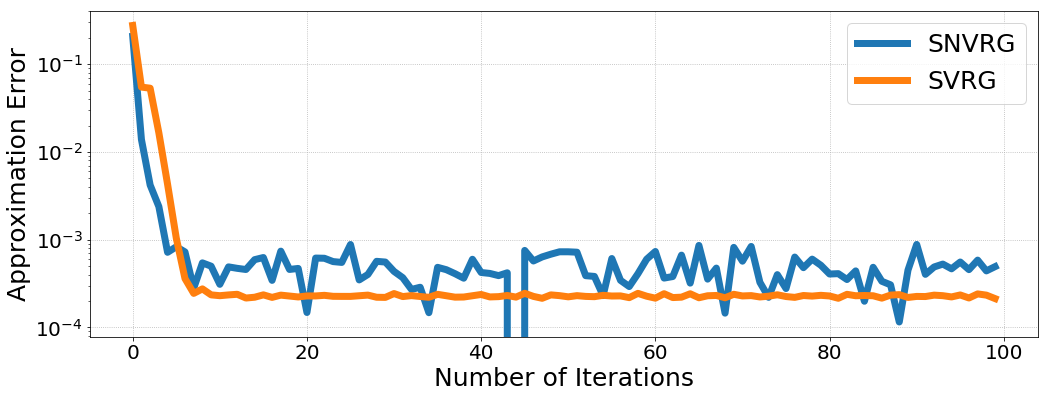

In [13]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the convergences of two algorithms are quite similar. Notice that SNVRG is more oscillating than SVRG which is because SNVRG chooses the parameter $\theta$ randomly in each epoch rather than taking the mean as in SVRG.

Now we test the performance of the real SNVRG by taking $K = 2$ as in the paper. And we choose the loop parameters $T_l = \{2, 2\}$, the batch parameters $B_l = \{128, 64\}$, the base batch size $B = 256$ and the step size parameter $M = 6L$ where $L$ is the Lipschitz constant, as suggested in the paper.

In [14]:
theta = np.random.randn(p)
loop_params = [2, 2]
base_batch_size = 256
batch_params = [128, 64]
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 6 * L
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

In [15]:
snvrg_min_loss = np.min(snvrg_loss_history)

In [16]:
min_loss = np.min([svrg_min_loss, snvrg_min_loss])

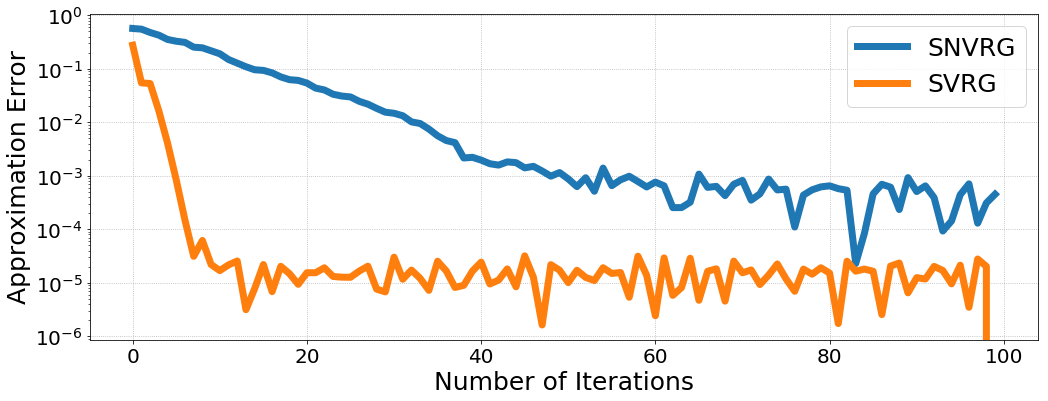

In [17]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the SNVRG converges slower at the beginning but it can attain similar performance as SVRG after around 50 iterations.

## 2. Non-convex Problem: MNIST dataset image classification
As presented in the paper, we take the image classification non-convex problem on MNIST dataset to see the performance of SNVRG.

In order to train the neural network efficiently, we use TensorFlow framework. Thus we reimplement the SNVRG algorithm in TensorFlow here.

In [18]:
import tensorflow as tf

In [19]:
# Image size in MNIST dataset is (28, 28), so the first convolutional layer is applied with SAME padding, to fit with the LeNet architecture
def CNN_LeNet(images, parameters):
    filter1, bias1, filter2, bias2, W1, b1, W2, b2, W3, b3 = parameters
    stride1 = [1, 1, 1, 1]
    kernel = [1, 2, 2, 1]
    stride2 = [1, 2, 2, 1]
    conv1 = tf.nn.conv2d(images, filter1, stride1, padding='SAME', name='Conv1') + bias1
    pool1 = tf.nn.max_pool(conv1, kernel, stride2, padding='VALID', name='MaxPool1')
    relu1 = tf.nn.relu(pool1, name='ReLU1')
    conv2 = tf.nn.conv2d(relu1, filter2, stride1, padding='VALID', name='Conv2') + bias2
    pool2 = tf.nn.max_pool(conv2, kernel, stride2, padding='VALID', name='MaxPool2')
    relu2 = tf.nn.relu(pool2, name='Relu2')
    size = relu2.get_shape().as_list()
    new_size = size[-1] * size[-2] * size[-3]
    flatten = tf.reshape(relu2, [-1, new_size])
    fc1 = tf.nn.relu(tf.matmul(flatten, W1) + b1, name='FC1')
    fc2 = tf.nn.relu(tf.matmul(fc1, W2) + b2, name='FC2')
    output = tf.nn.softmax(tf.matmul(fc2, W3) + b3, name='Output')
    
    return output

In [20]:
def loss(y, pred, regularization, parameters):
    filter1, bias1, filter2, bias2, W1, b1, W2, b2, W3, b3 = parameters
    cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), axis=-1))
    cost = cost + regularization * (tf.reduce_sum(tf.square(filter1)) + tf.reduce_sum(tf.square(filter2)))
    cost = cost + regularization * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2)) + tf.reduce_sum(tf.square(W3)))
    return cost

def grad_loss(cost, parameters):
    d_filter1, d_bias1, d_filter2, d_bias2, d_W1, d_b1, d_W2, d_b2, d_W3, d_b3 = tf.gradients(cost, parameters)
    return [d_filter1, d_bias1, d_filter2, d_bias2, d_W1, d_b1, d_W2, d_b2, d_W3, d_b3]

In [21]:
def one_epoch_SVRG_tf(X, y, parameters, regularization, max_iter_inner, step_size):
    n = X.get_shape().as_list()[0]
    parameters_history = []
    
    parameters_hat = parameters
    
    y_pred = CNN_LeNet(X, parameters)
    cost = loss(y, y_pred, regularization, parameters)
    full_gradient = grad_loss(cost, parameters_hat)
    
    for k in range(max_iter_inner):
        i = np.random.randint(0, n)
        y_pred_new = CNN_LeNet(X[i:i+1], parameters)
        cost_new = loss(y[i:i+1], y_pred_new, regularization, parameters)
        grad_new = grad_loss(cost_new, parameters)
        y_pred_old = CNN_LeNet(X[i:i+1], parameters_hat)
        cost_old = loss(y[i:i+1], y_pred_old, regularization, parameters_hat)
        grad_old = grad_loss(cost_old, parameters_hat)
        
        for j, _ in enumerate(parameters):
            parameters[j] = parameters[j] - step_size * (grad_new[j] - grad_old[j] + full_gradient[j])
        
        parameters_history.append(parameters)

    parameters_hat = []
    for j in range(len(parameters)):
        param_hat = parameters_history[0][j]
        for k in range(1, max_iter_inner):
            param_hat = param_hat + parameters_history[k][j]
        param_hat = param_hat / max_iter_inner
        parameters_hat.append(param_hat)

    y_pred = CNN_LeNet(X, parameters_hat)
    cost = loss(y, y_pred, regularization, parameters_hat)
    
    return parameters_hat, cost

In [22]:
def update_reference_points_tf(parameters_references, parameters, r):
    K = len(parameters_references)
    for i in range(r, K):
        parameters_references[i] = parameters
    return parameters_references
    
def update_reference_gradients_tf(X, y, gradients, parameters_references, regularization, r, batch_params, base_batch_size):
    n = X.get_shape().as_list()[0]
    K = len(parameters_references)
    for l in range(r, K):
        indexes = tf.random.shuffle(tf.range(n))
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            y_pred = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l])
            cost = loss(tf.gather(y, batch_indexes), y_pred, regularization, parameters_references[l])
            gradients[l] = grad_loss(cost, parameters_references[l])
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            y_pred_new = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l])
            cost_new = loss(tf.gather(y, batch_indexes), y_pred_new, regularization, parameters_references[l])
            grad_new = grad_loss(cost_new, parameters_references[l])
            y_pred_old = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l-1])
            cost_old = loss(tf.gather(y, batch_indexes), y_pred_old, regularization, parameters_references[l-1])
            grad_old = grad_loss(cost_old, parameters_references[l-1])
            for i in range(len(grad_new)):
                gradients[l][i] = grad_new[i] - grad_old[i]
            
    return gradients

In [23]:
def one_epoch_SNVRG_tf(X, y, parameters, regularization, loop_params, batch_params, base_batch_size, step_size):
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n = X.get_shape().as_list()[0]
    parameters_history = []
    
    parameters_references = []
    gradients = []
    for _ in range(K+1):
        param_references = []
        grad_references = []
        for param in parameters:
            param_references.append(param)
            grad_references.append(tf.zeros_like(param))
        parameters_references.append(param_references)
        gradients.append(grad_references)
        
    indexes = tf.random.shuffle(tf.range(n))
    base_batch = indexes[0:base_batch_size]
    y_pred = CNN_LeNet(tf.gather(X, base_batch), parameters)
    cost = loss(tf.gather(y, base_batch), y_pred, regularization, parameters)
    gradients[0] = grad_loss(cost, parameters)
    grads = gradients[0]
    for i in range(len(parameters)):
        for j in range(1, K+1):
            grads[i] = grads[i] + gradients[j][i]
            
        parameters[i] = parameters[i] - 0.1 / step_size * grads[i]
    
    parameters_history.append(parameters)
    
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        parameters_references = update_reference_points_tf(parameters_references, parameters, r)
        gradients = update_reference_gradients_tf(X, y, gradients, parameters_references, regularization, r, batch_params, base_batch_size)
        
        grads = gradients[0]
        for i in range(len(parameters)):
            for j in range(1, K+1):
                grads[i] = grads[i] + gradients[j][i]

            parameters[i] = parameters[i] - 0.1 / step_size * grads[i]
        parameters_history.append(parameters)
        
    final_parameters = parameters_history[np.random.choice(len(parameters_history), 1)[0]]
    y_pred = CNN_LeNet(X, final_parameters)
    final_loss = loss(y, y_pred, regularization, final_parameters)
    
    return final_parameters, parameters_history[-1], final_loss

In [24]:
def evaluate(X, y, parameters):
    y_pred = CNN_LeNet(X, parameters)
    preds = tf.argmax(y_pred, axis=1)
    err = 1. - tf.reduce_sum(tf.cast(tf.equal(y, preds), tf.float32)) / y.get_shape().as_list()[0]
    return err

In [25]:
# load MNIST dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train[:, :, :, np.newaxis], x_test[:, :, :, np.newaxis]

y_tr = np.zeros((y_train.shape[0], 10))
y_tr[np.arange(y_train.shape[0]), y_train] = 1
y_te = y_test

print(x_train.shape)
print(y_tr.shape)
print(y_te.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000,)


### Adam Optimizer

In [29]:
tf.reset_default_graph()

filter1 = tf.get_variable(name='filter1', shape=(5, 5, 1, 6), initializer=tf.glorot_uniform_initializer())
bias1 = tf.get_variable(name='bias1', initializer=tf.zeros((6)))
filter2 = tf.get_variable(name='filter2', shape=(5, 5, 6, 16), initializer=tf.glorot_uniform_initializer())
bias2 = tf.get_variable(name='bias2', initializer=tf.zeros((16)))
W1 = tf.get_variable(name='W1', shape=(400, 120), initializer=tf.glorot_uniform_initializer())
b1 = tf.get_variable(name='b1', initializer=tf.zeros((120)))
W2 = tf.get_variable(name='W2', shape=(120, 84), initializer=tf.glorot_uniform_initializer())
b2 = tf.get_variable(name='b2', initializer=tf.zeros(84))
W3 = tf.get_variable(name='W3', shape=(84, 10), initializer=tf.glorot_uniform_initializer())
b3 = tf.get_variable(name='b3', initializer=tf.zeros(10))

parameters = [filter1, bias1, filter2, bias2, W1, b1, W2, b2, W3, b3]
regularization = 0.0
lr = 0.01
epochs = 100
batch_size = 512
num_mini_batches = x_train.shape[0] // batch_size

X = tf.placeholder(dtype='float32', shape=(None, 28, 28, 1))
y = tf.placeholder(dtype='float32', shape=(None, 10))
lr_ph = tf.placeholder(dtype='float32', shape=())

X_test = tf.placeholder(dtype='float32', shape=(10000, 28, 28, 1))
y_test = tf.placeholder(dtype='int64', shape=(10000, ))

y_pred = CNN_LeNet(X, parameters)
cost = loss(y, y_pred, regularization, parameters)

opt = tf.train.AdamOptimizer(learning_rate=lr_ph)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
#     parameters_history = []
    adam_loss_history = []
    adam_test_error_history = []
    for epoch in range(epochs):
#         if epoch % 20 == 0:
#             lr *= 0.9
        print("Epoch {}/{}".format(epoch+1, epochs))
        indexes = np.arange(x_train.shape[0])
        np.random.shuffle(indexes)
        for batch in range(1):
#         for batch in range(num_mini_batches - 1):
            x_batch = x_train[indexes[batch * batch_size: (batch+1) * batch_size]]
            y_batch = y_tr[indexes[batch * batch_size: (batch+1) * batch_size]]
            _, c = sess.run([optimizer, cost], feed_dict={X: x_batch, y: y_batch, lr_ph: lr})
#             print("Batch: {}\t Loss: {}".format(batch, c))
            
#         x_batch = x_train[indexes[(batch+1) * batch_size:]]
#         y_batch = y_tr[indexes[(batch+1) * batch_size:]]
#         _, c = sess.run([optimizer, cost], feed_dict={X: x_batch, y: y_batch, lr_ph: lr})
# #         print("Batch: {}\t Loss: {}".format(batch+1, c))
        
        test_error = evaluate(X_test, y_test, parameters)
        err = sess.run(test_error, feed_dict={X_test: x_test, y_test: y_te})
        
        adam_loss_history.append(c)
        adam_test_error_history.append(err)
        print("\tLoss: {}\tTest Error: {}".format(c, err))

Epoch 1/100
	Loss: 2.297025680541992	Test Error: 0.9017999768257141
Epoch 2/100
	Loss: 2.245595932006836	Test Error: 0.6919000148773193
Epoch 3/100
	Loss: 2.108436107635498	Test Error: 0.5536999702453613
Epoch 4/100
	Loss: 1.7710793018341064	Test Error: 0.3849000334739685
Epoch 5/100
	Loss: 1.3572719097137451	Test Error: 0.37860000133514404
Epoch 6/100
	Loss: 1.124529242515564	Test Error: 0.5058000087738037
Epoch 7/100
	Loss: 1.5489146709442139	Test Error: 0.35190004110336304
Epoch 8/100
	Loss: 1.2563804388046265	Test Error: 0.34049999713897705
Epoch 9/100
	Loss: 1.0402867794036865	Test Error: 0.2646999955177307
Epoch 10/100
	Loss: 0.8104929327964783	Test Error: 0.27900004386901855
Epoch 11/100
	Loss: 0.8542360067367554	Test Error: 0.27310001850128174
Epoch 12/100
	Loss: 0.7827306389808655	Test Error: 0.2535000443458557
Epoch 13/100
	Loss: 0.7394123673439026	Test Error: 0.2232000231742859
Epoch 14/100
	Loss: 0.7224968075752258	Test Error: 0.1812000274658203
Epoch 15/100
	Loss: 0.529489

### SVRG Optimizer

In [28]:
tf.reset_default_graph()

filter1 = tf.get_variable(name='filter1', shape=(5, 5, 1, 6), initializer=tf.glorot_uniform_initializer())
bias1 = tf.get_variable(name='bias1', initializer=tf.zeros((6)))
filter2 = tf.get_variable(name='filter2', shape=(5, 5, 6, 16), initializer=tf.glorot_uniform_initializer())
bias2 = tf.get_variable(name='bias2', initializer=tf.zeros((16)))
W1 = tf.get_variable(name='W1', shape=(400, 120), initializer=tf.glorot_uniform_initializer())
b1 = tf.get_variable(name='b1', initializer=tf.zeros((120)))
W2 = tf.get_variable(name='W2', shape=(120, 84), initializer=tf.glorot_uniform_initializer())
b2 = tf.get_variable(name='b2', initializer=tf.zeros(84))
W3 = tf.get_variable(name='W3', shape=(84, 10), initializer=tf.glorot_uniform_initializer())
b3 = tf.get_variable(name='b3', initializer=tf.zeros(10))

parameters = [filter1, bias1, filter2, bias2, W1, b1, W2, b2, W3, b3]
regularization = 0.0
max_iter_inner = 64
lr = 0.01
epochs = 100
batch_size = 512
num_mini_batches = x_train.shape[0] // batch_size

X = tf.placeholder(dtype='float32', shape=(batch_size, 28, 28, 1))
y = tf.placeholder(dtype='float32', shape=(batch_size, 10))
step_size = tf.placeholder(dtype='float32', shape=())

X_test = tf.placeholder(dtype='float32', shape=(10000, 28, 28, 1))
y_test = tf.placeholder(dtype='int64', shape=(10000, ))

y_pred = CNN_LeNet(X, parameters)
cost = loss(y, y_pred, regularization, parameters)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
#     parameters_history = []
    svrg_loss_history = []
    svrg_test_error_history = []
    for epoch in range(epochs):
#         if epoch % 10 == 0:
#             lr *= 0.1
        print("Epoch {}/{}".format(epoch+1, epochs))
        indexes = np.arange(x_train.shape[0])
        np.random.shuffle(indexes)
        for batch in range(1):
#         for batch in range(num_mini_batches - 1):
            x_batch = x_train[indexes[batch * batch_size: (batch+1) * batch_size]]
            y_batch = y_tr[indexes[batch * batch_size: (batch+1) * batch_size]]
            parameters, c = one_epoch_SVRG_tf(X, y, parameters, regularization, max_iter_inner, step_size)
            param, cost = sess.run([parameters, c], feed_dict={X: x_batch, y: y_batch, step_size: lr})
            print("Batch: {}\t Loss: {}".format(batch, cost))
        
#         parameters_history.append(param_hat)
        test_error = evaluate(X_test, y_test, parameters)
        err = sess.run(test_error, feed_dict={X_test: x_test, y_test: y_te})
        
        svrg_loss_history.append(cost)
        svrg_test_error_history.append(err)
        print("\tLoss: {}".format(cost))
        print("\tTest Error: {}".format(err))

Epoch 1/20
Batch: 0	 Loss: 2.3166403770446777
Batch: 1	 Loss: 2.3234994411468506
Batch: 2	 Loss: 2.3162574768066406
Batch: 3	 Loss: 2.3295300006866455
Batch: 4	 Loss: 2.3226959705352783
Batch: 5	 Loss: 2.3185739517211914
Batch: 6	 Loss: 2.3135275840759277
Batch: 7	 Loss: 2.310361385345459
Batch: 8	 Loss: 2.300560712814331
Batch: 9	 Loss: 2.2969512939453125
Batch: 10	 Loss: 2.3140320777893066
Batch: 11	 Loss: 2.306520462036133
Batch: 12	 Loss: 2.315434217453003
Batch: 13	 Loss: 2.31846284866333
Batch: 14	 Loss: 2.298520803451538
Batch: 15	 Loss: 2.300766944885254
Batch: 16	 Loss: 2.300045967102051
Batch: 17	 Loss: 2.2987613677978516
Batch: 18	 Loss: 2.2928411960601807
Batch: 19	 Loss: 2.3043787479400635
Batch: 20	 Loss: 2.298440456390381
Batch: 21	 Loss: 2.3059768676757812
Batch: 22	 Loss: 2.294304609298706
Batch: 23	 Loss: 2.3008201122283936
Batch: 24	 Loss: 2.2963995933532715
Batch: 25	 Loss: 2.29807710647583
Batch: 26	 Loss: 2.2792723178863525
Batch: 27	 Loss: 2.2910618782043457
Batc

KeyboardInterrupt: ignored

In [36]:
tf.reset_default_graph()

filter1 = tf.get_variable(name='filter1', shape=(5, 5, 1, 6), initializer=tf.glorot_uniform_initializer())
bias1 = tf.get_variable(name='bias1', initializer=tf.zeros((6)))
filter2 = tf.get_variable(name='filter2', shape=(5, 5, 6, 16), initializer=tf.glorot_uniform_initializer())
bias2 = tf.get_variable(name='bias2', initializer=tf.zeros((16)))
W1 = tf.get_variable(name='W1', shape=(400, 120), initializer=tf.glorot_uniform_initializer())
b1 = tf.get_variable(name='b1', initializer=tf.zeros((120)))
W2 = tf.get_variable(name='W2', shape=(120, 84), initializer=tf.glorot_uniform_initializer())
b2 = tf.get_variable(name='b2', initializer=tf.zeros(84))
W3 = tf.get_variable(name='W3', shape=(84, 10), initializer=tf.glorot_uniform_initializer())
b3 = tf.get_variable(name='b3', initializer=tf.zeros(10))

parameters = [filter1, bias1, filter2, bias2, W1, b1, W2, b2, W3, b3]
regularization = 0.0
loop_params = [8, 8]
base_batch_size = 512
batch_params = [64, 4]
lr = 100.0
epochs = 100
batch_size = 512
num_mini_batches = x_train.shape[0] // batch_size

X = tf.placeholder(dtype='float32', shape=(batch_size, 28, 28, 1), name='X')
y = tf.placeholder(dtype='float32', shape=(batch_size, 10), name='y')
step_size = tf.placeholder(dtype='float32', shape=(), name='step')

X_test = tf.placeholder(dtype='float32', shape=(10000, 28, 28, 1), name='X_test')
y_test = tf.placeholder(dtype='int64', shape=(10000, ), name='y_test')

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
#     parameters_history = []
    snvrg_loss_history = []
    snvrg_test_error_history = []
    for epoch in range(epochs):
#         if epoch % 10 == 0:
#             lr *= 10
        print("Epoch {}/{}".format(epoch+1, epochs))
        indexes = np.arange(x_train.shape[0])
        np.random.shuffle(indexes)
        for batch in range(1):
#         for batch in range(num_mini_batches - 1):
            x_batch = x_train[indexes[batch * batch_size: (batch+1) * batch_size]]
            y_batch = y_tr[indexes[batch * batch_size: (batch+1) * batch_size]]
            parameters_hat, parameters, c = one_epoch_SNVRG_tf(X, y, parameters, regularization, loop_params, 
                                                                  batch_params, base_batch_size, step_size)
            param_hat, param, cost = sess.run([parameters_hat, parameters, c], 
                                                  feed_dict={X: x_batch, y: y_batch, step_size: lr})
            print("Batch: {}\t Loss: {}".format(batch, cost))
            

        test_error = evaluate(X_test, y_test, param_hat)
        err = sess.run(test_error, feed_dict={X_test: x_test, y_test: y_te})
        
        snvrg_loss_history.append(cost)
        snvrg_test_error_history.append(err)
        print("\tLoss: {}".format(cost))
        print("\tTest Error: {}".format(err))

Epoch 1/100
Batch: 0	 Loss: 2.284475326538086
	Loss: 2.284475326538086
	Test Error: 0.8460999727249146
Epoch 2/100
Batch: 0	 Loss: 2.2711002826690674
	Loss: 2.2711002826690674
	Test Error: 0.8377000093460083
Epoch 3/100
Batch: 0	 Loss: 2.262795925140381
	Loss: 2.262795925140381
	Test Error: 0.8446000218391418
Epoch 4/100
Batch: 0	 Loss: 2.2603368759155273
	Loss: 2.2603368759155273
	Test Error: 0.796500027179718
Epoch 5/100
Batch: 0	 Loss: 2.2330243587493896
	Loss: 2.2330243587493896
	Test Error: 0.7569000124931335
Epoch 6/100
Batch: 0	 Loss: 2.2126200199127197
	Loss: 2.2126200199127197
	Test Error: 0.7350000143051147
Epoch 7/100
Batch: 0	 Loss: 2.1837048530578613
	Loss: 2.1837048530578613
	Test Error: 0.6878000497817993
Epoch 8/100
Batch: 0	 Loss: 2.207174777984619
	Loss: 2.207174777984619
	Test Error: 0.7303000092506409
Epoch 9/100
Batch: 0	 Loss: 2.099020004272461
	Loss: 2.099020004272461
	Test Error: 0.6638000011444092
Epoch 10/100
Batch: 0	 Loss: 2.0052504539489746
	Loss: 2.0052504

KeyboardInterrupt: 

In [0]:
print(loss_his)

[0.51936007, -1.8262963, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
